
## Inicializar

In [ ]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.datasets        import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

Fijamos la semilla random para poder replicar los resultados:

In [ ]:
random_state = 42
random.seed(random_state)

Creamos un dataset de ejemplo con 4 features y 2 clases:

In [ ]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, random_state=random_state)

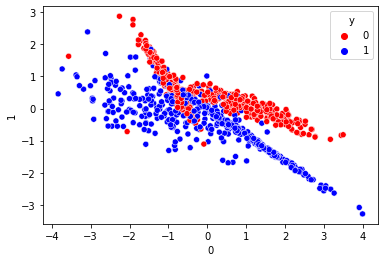

In [ ]:
def plot_data(X, y):
    df = pd.DataFrame(X)
    df['y'] = y
    sns.scatterplot(x=0, y=1, hue='y', palette={0:'r',1:'b'}, data=df, legend='brief' )

plot_data(X, y)

Partimos en 70% train y 30% para validation:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

Funciones de activacion:

In [ ]:
# Escalon
binary_step = lambda z: 1.0 if z >= 0 else 0.0

parametric_relu = lambda alpha: lambda z: np.maximum(0, z) * alpha

relu = parametric_relu(alpha=1)

leaky_relu = parametric_relu(alpha=0.01)

parametric_elu = lambda alpha: lambda z:  alpha * (np.exp(z) -1) if z < 0 else z

elu = parametric_elu(alpha=1.0)

sigmoid = lambda z: 1 / (1 + np.exp(-z))

identity = lambda z: z

tanh = lambda z: (2 / (1 + np.exp(-2 * z))) -1

arc_tan = lambda z: np.arctan(z)

Metrica a optimizar: Error cuadratico medio (MSE).

In [ ]:
mse = lambda y_true, x_true: sum((y_true - x_true) ** 2) / len(x_true)

Perceptron:

In [ ]:
class Perceptron:
    def __init__(self, act_fn, inputs_count):
        self.act_fn = act_fn
        # Initilizamos los pesos con valores random...
        self.weights = [random.random() for _ in range(0, inputs_count)]

    def predict(self, features):
        output = sum([w * f for w, f in zip(self.weights, features)])
        return self.act_fn(output)

    def fit(
        self, 
        X_train, y_train, X_val, y_val, 
        metric_fn, 
        learning_rate, 
        epocs,
        verbose=False
    ):
        summary = []

        # Repetimos el proceso de entenamiento "epocs" veces...
        for epoc in range(1, epocs -1):
            
            # Ajustamos los pesos del modelo...
            for features, y_true in zip(X_train, y_train):
                y_pred = self.predict(features)
                self.__back_propagation(features, y_pred, y_true, learning_rate)

            # Calculamos la metrica para el conjunto de validacion y train
            metric_values = self.__calculate_metric(
                metric_fn, 
                X_train, y_train,  
                X_val, y_val
            )
            if verbose:
                print(f'epoc: {epoc}, train: {metric_values[0]}, val: {metric_values[1]}')
            
            summary.append(metric_values)

        return summary

    def __back_propagation(self, features, y_pred, y_true, learning_rate):
        # Ajustamos los pesos del modelo, dado un ejemplo a aprender...
        for index, feature in enumerate(features):
            self.weights[index] += learning_rate * (y_true - y_pred) * feature

    def __calculate_metric(self, metric_fn, X_train, y_train, X_val, y_val):
        train_metric_value = metric_fn([self.predict(x) for x in X_train], y_train)                                                                                    
        val_metric_value   = metric_fn([self.predict(x) for x in X_val], y_val)
        return train_metric_value, val_metric_value

Funcion para graficar train vs validation:

In [ ]:
def plot_metrics(summary):
    sns.set_style("darkgrid")
    sns.lineplot(data=[summary[i][0] for i in range(0, len(summary))], label='Train')
    sns.lineplot(data=[summary[i][1] for i in range(0, len(summary))], label='Validation')
    plt.xlabel("Epocs")
    plt.ylabel("MSE")
    plt.title("MSE: Train vs. Validation")
    plt.show()

Objeto que permite realizar corridas del modelo con distintos hiper-parametros 

1.   Elemento de lista
2.   Elemento de lista

y ademas grafica las curvas de evolucion de la metrica elegida (MSE) en train y evaluation: 

In [ ]:
class ModelTest:
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val   = X_val
        self.y_val   = y_val
        # La cantidad de entradas es igual a la cantidad de features...
        self.inputs_count = len(X_train[0])

    def perform(
        self,
        # Function de activacion
        act_fn, 
        metric_fn     = mse,
        learning_rate = 0.00001, 
        epocs         = 350,
        verbose       = False
    ):
        model = Perceptron(act_fn, self.inputs_count)

        summary = model.fit(
            self.X_train,
            self.y_train,
            self.X_val, 
            self.y_val,
            metric_fn,
            learning_rate, 
            epocs,
            verbose
        )

        plot_metrics(summary)

        print('Val MSE:', summary[-1][1])        

In [ ]:
test = ModelTest(X_train, y_train, X_val, y_val)

## Aprender

Aprendizaje usando la funcion de activación escalon:

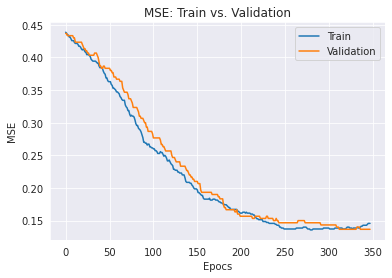

Val MSE: 0.13666666666666666


In [ ]:
test.perform(act_fn = binary_step)

Aprendizaje usando la funcion de activación Sigmoide:

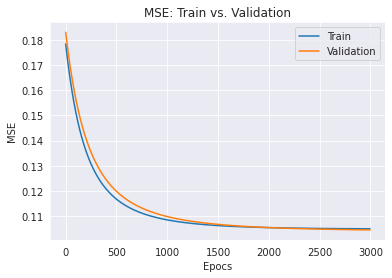

Val MSE: 0.1046106995402979


In [ ]:
test.perform(act_fn = sigmoid, epocs = 3_000)

Aprendizaje usando la funcion de activación ReLU:

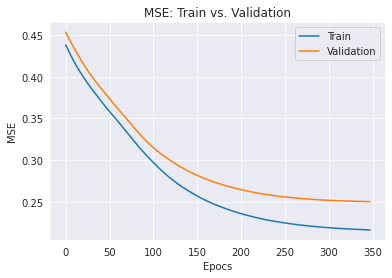

Val MSE: 0.2501509309059131


In [ ]:
test.perform(act_fn = relu)

Aprendizaje usando la funcion de activación Leaky-ReLU:

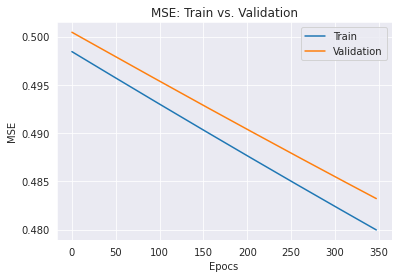

Val MSE: 0.48321526664403375


In [ ]:
test.perform(act_fn = leaky_relu)

Aprendizaje usando la funcion de activación Parametric-ReLU:

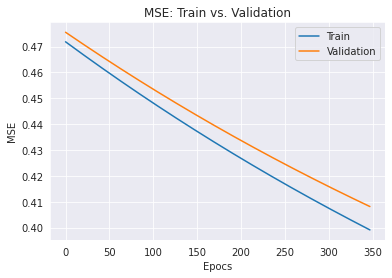

Val MSE: 0.40815524249911583


In [ ]:
test.perform(act_fn = parametric_relu(alpha = 0.05))

Aprendizaje usando la funcion de activación Identidad:

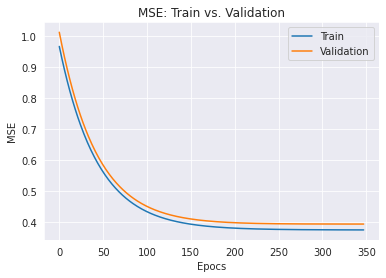

Val MSE: 0.39382584828503153


In [ ]:
test.perform(act_fn = identity)

Aprendizaje usando la funcion de activación tangente hiperbólica:

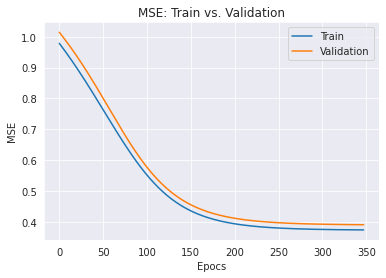

Val MSE: 0.39040190098553484


In [ ]:
test.perform(act_fn = tanh)

Aprendizaje usando la funcion de activación ELU:

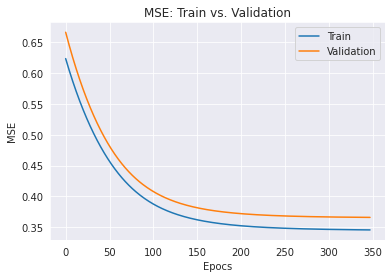

Val MSE: 0.3660987992817198


In [ ]:
test.perform(act_fn = elu)

Aprendizaje usando la funcion de activación Parametric-ELU:

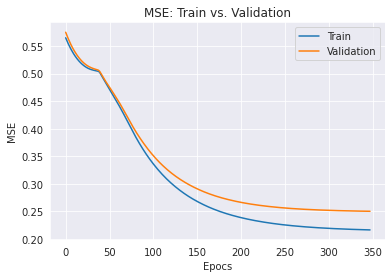

Val MSE: 0.25036660880053013


In [ ]:
test.perform(act_fn = parametric_elu(alpha = 0.001))

Aprendizaje usando la funcion de activación arcotangente:

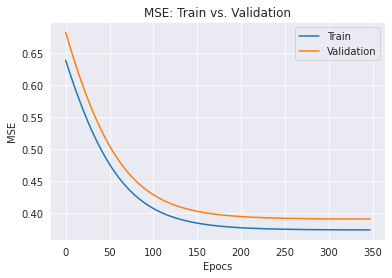

Val MSE: 0.3899940672907819


In [ ]:
test.perform(act_fn = arc_tan)

[Un ejemplo un poco mas complejo](https://github.com/adrianmarino/neural-network-from-scratch/blob/master/Neural_network_from_scratch.ipynb): Es una red multi-capa densa (Cada neurona se conecta con todas las neuronas de la capa anterior).